In [1]:
import warnings
import pandas as pd
import xgboost as xgb
import codes.utils as utils

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
# Load mock data with three tumor samples
patients_df = pd.read_csv('data/mock_n_3_data/mock_clinical_patients_data_n_3.txt', sep='\t')
samples_df = pd.read_csv('data/mock_n_3_data/mock_clinical_samples_data_n_3.txt', sep='\t')
mutations_df = pd.read_csv('data/mock_n_3_data/mock_mutations_data_n_3.txt', sep='\t')
cna_df = pd.read_csv('data/mock_n_3_data/mock_CNA_data_n_3.txt', sep='\t')

In [3]:
# Get features and labels for OncoNPC predictive inference
df_features_genie_final, df_labels_genie = utils.get_onconpc_features_from_raw_data(
    patients_df,
    samples_df,
    mutations_df,
    cna_df,
    features_onconpc_path='data/features_onconpc.pkl',
    combined_cohort_age_stats_path='data/combined_cohort_age_stats.pkl',
    mut_sig_weights_filepath='data/mutation_signatures/sigProfiler*.csv'
)

In [7]:
# Load fully trained OncoNPC model
xgb_onconpc = xgb.Booster()
xgb_onconpc.load_model('model/xgboost_v1.7.6_OncoNPC_full.json')

# Specify cancer types to consider
cancer_types_to_consider = ['Acute Myeloid Leukemia', 'Bladder Urothelial Carcinoma', 'Cholangiocarcinoma',
                            'Colorectal Adenocarcinoma', 'Diffuse Glioma', 'Endometrial Carcinoma',
                            'Esophagogastric Adenocarcinoma', 'Gastrointestinal Neuroendocrine Tumors', 'Gastrointestinal Stromal Tumor',
                            'Head and Neck Squamous Cell Carcinoma', 'Invasive Breast Carcinoma', 'Melanoma', 'Meningothelial Tumor',
                            'Non-Hodgkin Lymphoma', 'Non-Small Cell Lung Cancer', 'Ovarian Epithelial Tumor', 'Pancreatic Adenocarcinoma',
                            'Pancreatic Neuroendocrine Tumor', 'Pleural Mesothelioma', 'Prostate Adenocarcinoma', 'Renal Cell Carcinoma',
                            'Well-Differentiated Thyroid Cancer']
# Predict primary sites of CUP tumors
preds_df = utils.get_xgboost_latest_cancer_type_preds(xgb_onconpc,
                                                      df_features_genie_final,
                                                      cancer_types_to_consider)

In [8]:
# Get SHAP values for CUP tumors
warnings.filterwarnings('ignore')
shaps = utils.obtain_shap_values_with_latest_xgboost(xgb_onconpc, df_features_genie_final)

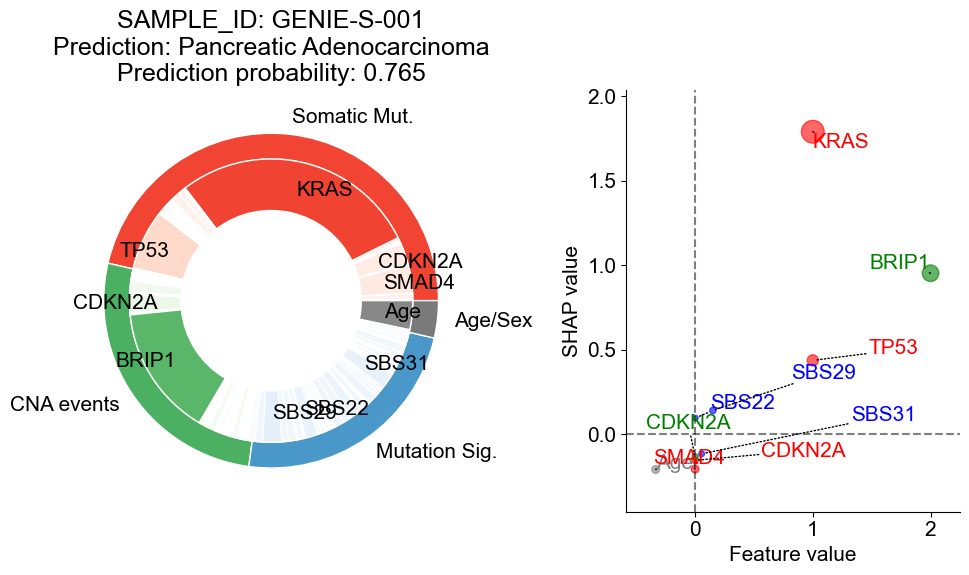

Explanation plot saved at others_prediction_explanation/GENIE-S-001.pdf


<Figure size 640x480 with 0 Axes>

In [11]:
query_ids = list(samples_df.SAMPLE_ID.values)
results = utils.get_onconpc_prediction_explanations(query_ids, preds_df, shaps,
                                                    df_features_genie_final,
                                                    cancer_types_to_consider,
                                                    save_plot=True)

In [33]:
results[query_ids[0]]

{'pred_prob': 0.7648269,
 'pred_cancer': 'Pancreatic Adenocarcinoma',
 'explanation_plot': 'others_prediction_explanation/GENIE-MSK-P-0024613-T01-IM6.pdf'}